In [ ]:
notebook_dir = %pwd                                                     
%matplotlib inline                               
import pysces                                                           
import psctb                                                            
import numpy                                                            
from os import path                                                     
from IPython.display import display, Image                              

# Thermokin

Thermokin is used to assess the kinetic and thermodynamic aspects of enzyme catalysed reactions in metabolic pathways [[5]](references.html). It provides the functionality to automatically separate the rate equations of reversible reactions into a *mass-action* ($v_{ma}$) term and a combined *binding* ($v_{\Theta}$) and *rate capacity* ($v_{cap}$) term, however rate equations may be manually split into any arbitrary terms if more granularity is required. Additionally $\Gamma/K_{eq}$ is calculated automatically for reversible reactions. Subsequently, elasticity coefficients for the different rate equation terms are automatically calculated. Similar to symbolic control coefficient and control pattern expressions of [Symca](Symca.ipynb), the term and elasticity expressions generated by Thermokin can be inspected and manipulated with standard `SymPy` functionality and their values are automatically recalculated upon a steady-state recalculation.

..note:: Here we use the word "term" to refer to the terms of the logarithmic form of a rate equation *as well as to the corresponding factors of its linear (conventional) form*. While not technically correct, this terminology is used in accordance to the original publication [[5]](references.html). 

## Features

* Automatically separates rate equations into a mass-action term and a combined binding and rate capacity terms.
* Allows for splitting rate equations into arbitrary terms.
* Determines a $\Gamma/K_{eq}$ expression for reversible reactions.
* Determines elasticity coefficient expressions for each reaction and its associated terms.
* Calculates values of for reaction rate terms, $\Gamma/K_{eq}$, and elasticity coefficients when a new steady-state is reached.
* The effect of a parameter change on the reaction rate terms, $\Gamma/K_{eq}$, and elasticity coefficients can be investigated by performing a parameter scan and visualised usig `ScanFig`.
* Loading of split rate equation terms
* Saving of Thermokin results

## Usage and feature walkthrough

### Workflow

Assessing the kinetic and thermodynamic aspects of enzyme catalysed reactions using `Thermokin` requires the following steps:

1. Instantiation of a `Thermokin` object using a `PySCeS` model object and (optionally) a file in which the rate equations of the model has been split into separate terms. 
2. Accessing rate equation terms via `reaction_results` and the corresponding reaction name, reaction term name, or $\Gamma/K_{eq}$ name.
3. Accessing elasticity coefficient terms via `ec_results` and the corresponding elasticity coefficient name.
4. Inspection of the values of the various terms and elasticity coefficients.
5. Inspection of the effect of parameter changes on the values of the rate equation terms and elasticity coefficients.
6. Result saving.
7. Further analysis.

### Rate term file syntax

As previously mentioned, Thermokin will attempt to automatically split the rate equations of reversible reactions into separate terms. While this feature should work for most common rate equations and does not require any user intervention or knowledge of the parameter names used in the model file, it is limited in two significant ways:

1. The algorithm cannot distinguish between the binding and rate capacity terms and can therefore not separate them. This is a minor issue if the focus of the analysis will be on the elasticity coefficients of the different terms, as the combined rate capacity and binding term elasticity coefficient will be identical to that of the binding term alone.
2. The algorithm cannot separate the effect of single subunit binding from that of cooperative binding.

Additionally, the algorithm can fail in some instances. 

For these reasons the separate rate equation terms can be manually defined in a `.reqn` file using a relatively simple syntax. Below follows such a file as automatically generated for the model `lin4_fb.psc`:

```
# Automatically parsed and split rate equations for model: lin4_fb.psc
# generated on: 13:49:07 12-01-2017

# Note that this is a best effort attempt that is highly dependent
# on the form of the rate equations as defined in the model file.
# Check correctness before use.

# R1 :successful separation of rate equation terms
!T{R1}{ma} X0 - S1/Keq_1
!T{R1}{bind_vc} 1.0*Vf_1*(S1/S1_05_1 + X0/X0_05_1)**(h_1 - 1.0)*(a_1*(S3/S3_05_1)**h_1 + 1)/(X0_05_1*(a_1*(S3/S3_05_1)**h_1*(S1/S1_05_1 + X0/X0_05_1)**h_1 + (S3/S3_05_1)**h_1 + (S1/S1_05_1 + X0/X0_05_1)**h_1 + 1))
!G{R1}{gamma_keq} S1/(Keq_1*X0)

# R2 :successful separation of rate equation terms
!T{R2}{ma} S1 - S2/Keq_2
!T{R2}{bind_vc} 1.0*S2_05_2*Vf_2/(S1*S2_05_2 + S1_05_2*S2 + S1_05_2*S2_05_2)
!G{R2}{gamma_keq} S2/(Keq_2*S1)

# R3 :successful separation of rate equation terms
!T{R3}{ma} S2 - S3/Keq_3
!T{R3}{bind_vc} 1.0*S3_05_3*Vf_3/(S2*S3_05_3 + S2_05_3*S3 + S2_05_3*S3_05_3)
!G{R3}{gamma_keq} S3/(Keq_3*S2)

# R4 :rate equation not included - irreversible or unknown form
```

Two types of "terms" can be defined in a `.reqn` file. The first type denoted by `!T`, is factor of the rate equation. When the `!T` terms for a reaction are multiplied together, they should result in the original rate equation.

Secondly `!G` terms are any arbitrary terms that could contain some useful information. Unlike the `!T` terms, the `!G` are not subject to any restrictions in terms of the value of their product or otherwise. For instance, the `!G` terms are used for define $\Gamma/K_{eq}$ for reversible reactions.

The syntax for `!T` and `!G` terms are as follows:
```
!T{%reaction_name}{%term_name} %term_expression

!G{%reaction_name}{%term_name} %term_expression
```

* `%reaction_name` - The name of the reaction to which the term belongs as defined in the `.psc` file (see the [PySCeS MDL documentation](http://pysces.sourceforge.net/docs/inputfile_doc.html)).
* `%term_name` - The name of the term. While this name is arbitrary, there can be no duplication for any single reaction.
* `%term_expression` - The expression of the term. 

Thus using the example provided above for reaction 3 the line `!T{R3}{ma} S2 - S3/Keq_3` specifies a `!T` term belonging to reaction 3 with the name `ma` and the expression `S2 - S3/Keq_3`.





### Object instantiation

Instantiation of a `Thermokin` analysis object requires `PySCeS` model object (`PysMod`) as an argument. Optionally a `.reqn` file can be provided that includes specifically slit rate equations. If path is provided, `Thermokin` will attempt to automatically split the reversible rate equations as described above and save a `.reqn` file at `~/Pysces/psc/%model_name.reqn`. If this file already exists, `ThermiKin` will load it instead. Using the included [lin4_fb.psc](http://pyscestoolbox.readthedocs.io/en/latest/included_files.html) model a `Thermokin` session is instantiated as follows:

In [2]:
mod = pysces.model('lin4_fb')
mod.doLoad() # this method call is necessary to ensure that future `doLoad` method calls are executed correctly
tk = psctb.ThermoKin(mod)

Assuming extension is .psc
Using model directory: /home/carl/Pysces/psc
/home/carl/Pysces/psc/lin4_fb.psc loading ..... 
Parsing file: /home/carl/Pysces/psc/lin4_fb.psc
Info: "X4" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . .  done.
 
PySCeS now automatically loads the model on model object instantiation. If you do not want this behaviour pass the autoload=False argument to the constructor, if you really want to reload the model, run doLoad() again.

Further calls to doLoad() will work as normal.


Now that `ThermoKin` has automatically generated a `.reqn` file for `lin4_fb.psc`, we can load that file manually during instantiation as follows:

In [3]:
tk = psctb.ThermoKin(mod,path.expanduser('~/Pysces/psc/lin4_fb.reqn'))

If the path specified does not exist, a new `.reqn` file will be generated there instead.

Finally, `ThermoKin` can also be forced to regenerate a the `.reqn` file by setting the `overwrite` argument to `True`:

In [4]:
tk = psctb.ThermoKin(mod,overwrite=True)

The file /home/carl/Pysces/psc/lin4_fb.reqn will be overwritten with automatically generated file.
R4        : rate equation not included - irreversible or unknown form
R1        : successful separation of rate equation terms
R2        : successful separation of rate equation terms
R3        : successful separation of rate equation terms


### Accessing results

Unlike `RateChar` and `Symca`, `ThermoKin` generates results immediately after instantiation. Results are organised similar to the other two modules, however, and can be found in the `reaction_results` and `ec_results` objects:

In [5]:
tk.reaction_results

$J_{R1}$,44.618
$J_{{R1}_{bindvc}}$,44.661
$J_{{R1}_{gammakeq}}$,9.599e-04
$J_{{R1}_{ma}}$,0.999
$J_{R2}$,44.618
$J_{{R2}_{bindvc}}$,5081.101
$J_{{R2}_{gammakeq}}$,0.909
$J_{{R2}_{ma}}$,0.009
$J_{R3}$,44.618
$J_{{R3}_{bindvc}}$,1036.279
$J_{{R3}_{gammakeq}}$,0.951


In [6]:
tk.ec_results

$\varepsilon^{R1}_{Keq1}$,9.608e-04
$\varepsilon^{R1}_{S1}$,-9.363e-04
$\varepsilon^{R1}_{S1051}$,-2.451e-05
$\varepsilon^{R1}_{S3}$,-2.888
$\varepsilon^{R1}_{S3051}$,2.888
$\varepsilon^{R1}_{Vf1}$,1.000
$\varepsilon^{R1}_{X0}$,3.554
$\varepsilon^{R1}_{X0051}$,-3.553
$\varepsilon^{R1}_{a1}$,0.062
$\varepsilon^{R1}_{h1}$,-1.461
$\varepsilon^{R2}_{Keq2}$,9.931


Each results object contains a variety of fields containing data related to a specific term or expression and may be accessed in a similar way to the results of `Symca`:

* Inspecting an individual reactions, terms, or elasticity coefficient yields a symbolic expression together with a value

In [7]:
# The binding*v_cap term of reaction 1
tk.reaction_results.J_R1_bind_vc

* `SymPy` expressions can be accessed via the `expression` field

In [8]:
tk.reaction_results.J_R1_bind_vc.expression

1.0*Vf_1*(S1/S1_05_1 + X0/X0_05_1)**(h_1 - 1.0)*(a_1*(S3/S3_05_1)**h_1 + 1)/(X0_05_1*(a_1*(S3/S3_05_1)**h_1*(S1/S1_05_1 + X0/X0_05_1)**h_1 + (S3/S3_05_1)**h_1 + (S1/S1_05_1 + X0/X0_05_1)**h_1 + 1))

* Values of the reaction, term, or elasticity coefficients

In [9]:
tk.reaction_results.J_R1_bind_vc.value

44.660921051608447

Additionally the `latex_name`, `latex_expression`, and parent model `mod` can also be accessed

In order to promote a logical and exploratory approach to investigating data generated by `ThermoKin`, the results are also arranged in a manner in which terms and elasticity coefficients associated with a certain reaction can be found nested within the results for that reaction. Using reaction 1 (called `J_R1` to signify the fact that its rate is at steady state) as an example, results can also be accessed in the following manner:

In [10]:
# The reaction can also be accessed at the root level of the ThermoKin object
# and the binding*v_cap term is nested under it.
tk.J_R1.bind_vc

In [11]:
# A reaction or term specific ec_results object is also available
tk.J_R1.bind_vc.ec_results.pecR1_X0_bind_vc

In [12]:
# All the terms of a specific reaction can be accessed via `terms`
tk.J_R1.terms

$J_{{R1}_{bindvc}}$,44.661
$J_{{R1}_{gammakeq}}$,9.599e-04
$J_{{R1}_{ma}}$,0.999


While each reaction/term/elasticity coefficient may be accessed in multiple ways, these fields are all references to the same result object. Modifying a term accessed in one way, therefore affects all references to the object.

### Dynamic value updating

The values of the reactions/terms/elasticity coefficients are automatically updated when a new steady state is calculated for the model. Thus changing a parameter of `lin4_hill`, such as the $V_{f}$ value of reaction 3, will lead to new values:

In [13]:
# Original value of J_R3
tk.J_R3

In [14]:
mod.doLoad()
# mod.Vf_3 has a default value of 1000
mod.Vf_3 = 0.1
# calculating new steady state
mod.doState()


Parsing file: /home/carl/Pysces/psc/lin4_fb.psc
Info: "X4" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . .  done.
 
INFO: (hybrd) Invalid steady state:
(hybrd) The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
WARNING!! Negative concentrations detected.
INFO: STATE is switching to NLEQ2 solver.
(nleq2) The solution converged.


In [15]:
# New value (original was 44.618)
tk.J_R3

In [16]:
# resetting to default Vf_3 value and recalculating
mod.doLoad()
mod.doState()


Parsing file: /home/carl/Pysces/psc/lin4_fb.psc
Info: "X4" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . .  done.
Calculating K matrix . . . . . . .  done.
 
(hybrd) The solution converged.


### Parameter scans

Parameter scans can be performed in order to determine the effect of a parameter change on a 
reaction rate and its individual terms or on the elasticity coefficients relating to a particular reaction and its related term elasticity coefficients (denoted as `pec%reaction_%modifier_%term` see [basic_usage#syntax](basic_usage.ipynb#syntax)) . The procedure for both the "value" and "elasticity" scans are very much the same and rely on the same principles as described under [basic_usage#plotting-and-displaying-results](basic_usage.ipynb#plotting-and-displaying-results).

To perform a parameter scan the `do_par_scan` method is called. This method has the following arguments:

* `parameter`: A String representing the parameter which should be varied.
* `scan_range`: Any iterable representing the range of values over which to vary the parameter (typically a NumPy `ndarray` generated by `numpy.linspace` or `numpy.logspace`).
* `scan_type`: Either `"elasticity"` or `"value"` as described above (*default*: `"value"`).
* `init_return`: If `True` the parameter value will be reset to its initial value after performing the parameter scan (*default*: `True`).
* `par_scan`: If `True`, the parameter scan will be performed by multiple parallel processes rather than a single process, thus speeding performance (*default*: `False`).
* `par_engine`: Specifies the engine to be used for the parallel scanning processes. Can either be `"multiproc"` or `"ipcluster"`. A discussion of the differences between these methods are beyond the scope of this document, see [here](http://www.davekuhlman.org/python_multiprocessing_01.html) for a brief overview of Multiprocessing in Python. (*default*: `"multiproc"`).

Below we will perform a value scan of the effect of $V_{f^3}$ on the terms of reaction 1 for 200 points between 0.01 and 100000 in log space:

In [17]:
valscan = tk.J_R1.do_par_scan('Vf_3',scan_range=numpy.logspace(-2,5,200),scan_type='value')

MaxMode 0
0 min 0 sec
SCANNER: Tsteps 200

SCANNER: 200 states analysed

(hybrd) The solution converged.


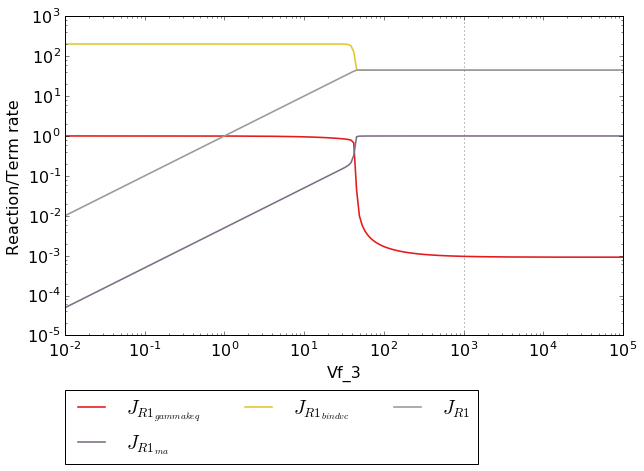

In [18]:
valplot = valscan.plot()

# Equivalent to clicking the corresponding buttons
valplot.toggle_category('J_R1', True)
valplot.toggle_category('J_R1_bind_vc', True)
valplot.toggle_category('J_R1_gamma_keq', True)
valplot.toggle_category('J_R1_ma', True)

valplot.interact()


Similarly, we can perform an elasticity scan using the same parameters:

In [19]:
ecscan = tk.J_R1.do_par_scan('Vf_3',scan_range=numpy.logspace(-2,5,200),scan_type='elasticity')

MaxMode 0
0 min 0 sec
SCANNER: Tsteps 200

SCANNER: 200 states analysed

(hybrd) The solution converged.


.. note:: Elasticity coefficients with expression equal to zero (which will by definition have zero values regardless of any parameter values) are ommitted from the parameter scan results even though they are included in the `ec_results` objects.

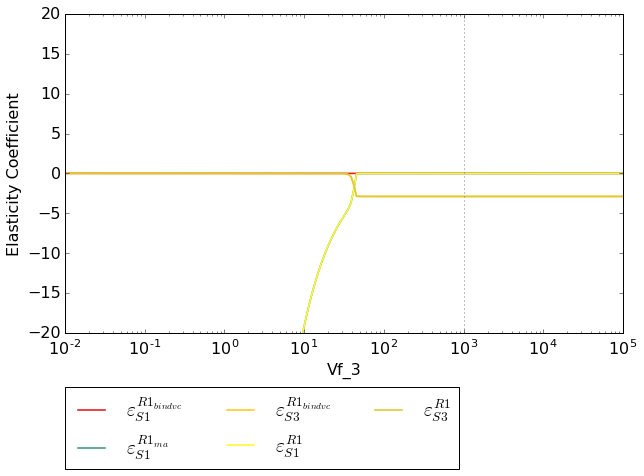

In [20]:
ecplot = ecscan.plot()

# All term elasticity coefficients are enabled
# by default, thus only the "full" elasticity 
# coefficients need to be enabled. Here we
# switch on the elasticity coefficients 
# representing the sensitivity of R1 with 
# respect to the substrate S1 and the inhibitor
# S3.
ecplot.toggle_category('ecR1_S1', True)
ecplot.toggle_category('ecR1_S3', True)

# The y limits are adjusted below as the elasticity 
# values of this parameter scan have extremely
# large magnitudes at low Vf_3 values
ecplot.ax.set_ylim((-20,20))

ecplot.interact()


### Saving results

In addition to being able to save parameter scan results (as previously described in [basic_usage#scanfig](basic_usage.ipynb#scanfig)), a summary of the results found in `reaction_results` and `ec_results` can be saved using the `save_results` method. This saves a `csv` file (by default) to disk to any specified location. If no location is specified, a file named `tk_summary_N` is saved to the `~/Pysces/$modelname/thermokin/` directory, where `N` is a number starting at 0:


In [21]:
tk.save_results()

`save_results` has the following optional arguments:

* `file_name`: Specifies a path to save the results to. If `None`, the path defaults as described above.
* `separator`: The separator between fields (*default*: `","`)

The contents of the saved data file is as follows:

In [22]:
# the following code requires `pandas` to run
import pandas as pd
# load csv file at default path
saved_results = pd.read_csv(path.expanduser('~/Pysces/lin4_fb/thermokin/tk_summary_0.csv'))
# show first 20 lines
saved_results.head(n=20) 

,# name,value,latex_name,latex_expression
0,J_R1,44.618051,J_{R1},\frac{1.0 \cdot Vf_{1} \cdot \left(Keq_{1} \cd...
1,J_R1_bind_vc,44.660921,J_{{R1}_{bindvc}},\frac{1.0 \cdot Vf_{1} \cdot \left(\frac{S_{1}...
2,J_R1_gamma_keq,0.000960,J_{{R1}_{gammakeq}},\frac{S_{1}}{Keq_{1} \cdot X_{0}}
3,J_R1_ma,0.999040,J_{{R1}_{ma}},\frac{Keq_{1} \cdot X_{0} - S_{1}}{Keq_{1}}
4,J_R2,44.618051,J_{R2},\frac{1.0 \cdot S_{2052} \cdot Vf_{2} \cdot \l...
5,J_R2_bind_vc,5081.100949,J_{{R2}_{bindvc}},\frac{1.0 \cdot S_{2052} \cdot Vf_{2}}{S_{1} \...
6,J_R2_gamma_keq,0.908520,J_{{R2}_{gammakeq}},\frac{S_{2}}{Keq_{2} \cdot S_{1}}
7,J_R2_ma,0.008781,J_{{R2}_{ma}},\frac{Keq_{2} \cdot S_{1} - S_{2}}{Keq_{2}}
8,J_R3,44.618051,J_{R3},\frac{1.0 \cdot S_{3053} \cdot Vf_{3} \cdot \l...
9,J_R3_bind_vc,1036.279489,J_{{R3}_{bindvc}},\frac{1.0 \cdot S_{3053} \cdot Vf_{3}}{S_{2} \...
